# Test plane-based registration

In [117]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os
import time

import planeslam.io as io
from planeslam.general import plot_3D_setup, color_legend
from planeslam.scan import pc_to_scan
from planeslam.registration import get_correspondences, extract_corresponding_features
from planeslam.geometry.util import quat_to_rot_mat

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Test with two planes

In [89]:
from planeslam.geometry.plane import BoundedPlane
from planeslam.registration import expmap
from planeslam.scan import Scan
import copy

V1 = np.array([[-1, 1, -1],
              [1, 1, -1],
              [1, 1, 1],
              [-1, 1, 1]])
V2 = np.array([[-1, -1, -1],
              [-1, 1, -1],
              [-1, 1, 1],
              [-1, -1, 1]])
P = Scan([BoundedPlane(V1), BoundedPlane(V2)])

# Ground-truth transformation
t_gt = np.array([0, -0.5, 0])[:,None]
u = np.array([0, 1, 0])[:,None]
theta = np.pi/12
R_gt = expmap(theta*u.flatten())

print("t_gt: ", t_gt)
print("R_gt: ", R_gt)

Q = copy.deepcopy(P)
Q.transform(R_gt, t_gt.flatten())

vertex and face generation not yet implemented
t_gt:  [[ 0. ]
 [-0.5]
 [ 0. ]]
R_gt:  [[ 0.96592583  0.          0.25881905]
 [ 0.          1.          0.        ]
 [-0.25881905  0.          0.96592583]]


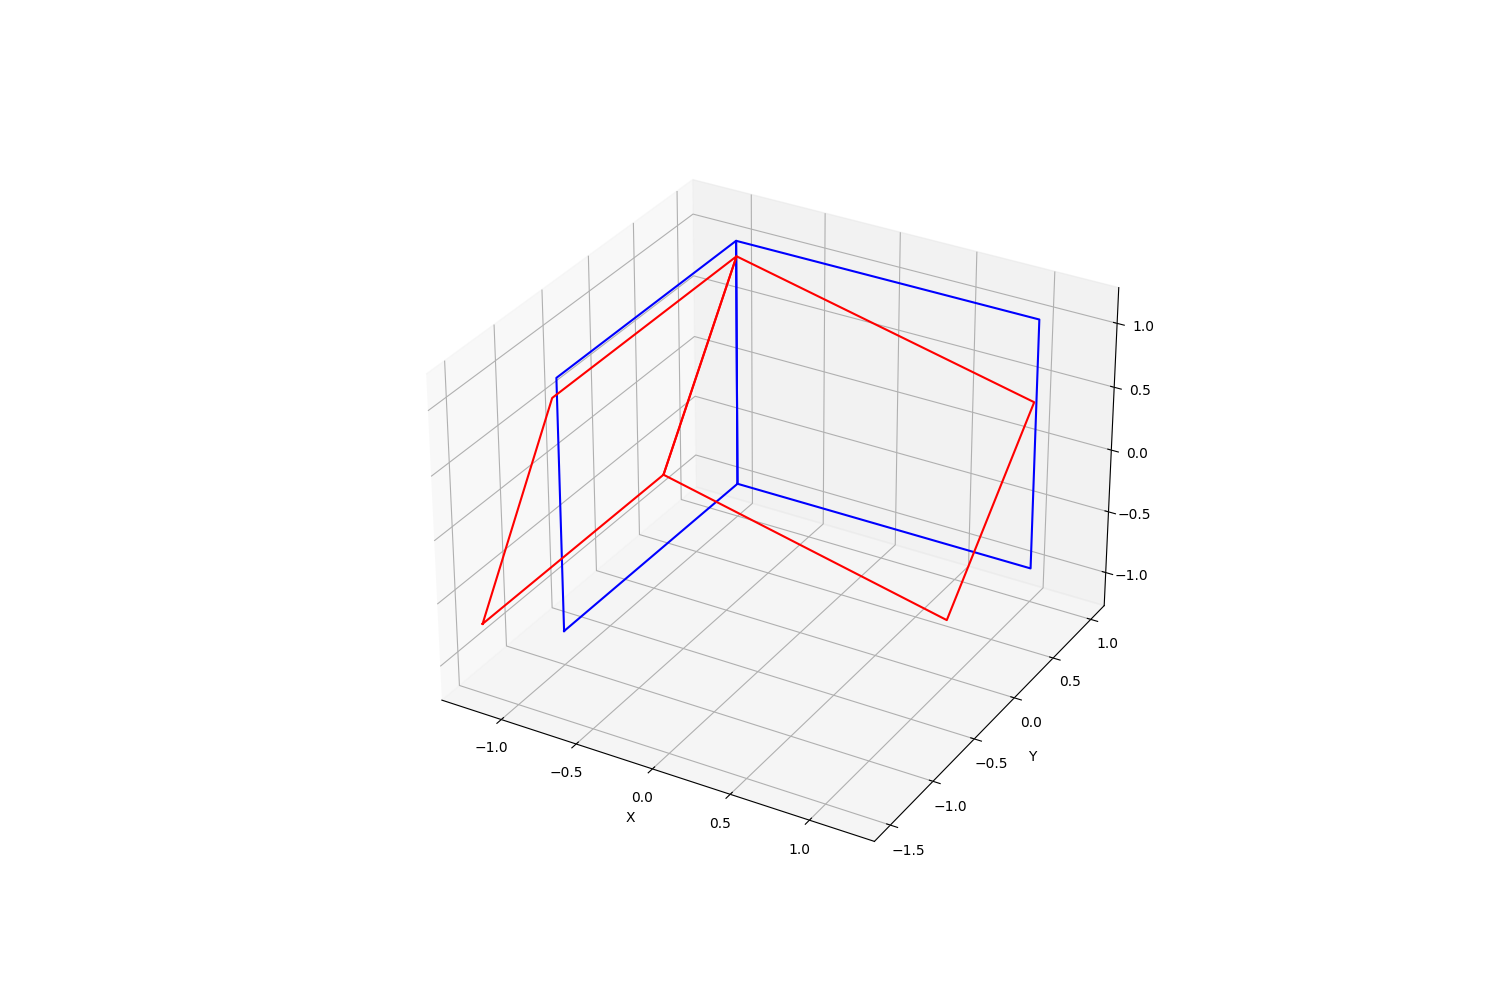

In [90]:
ax = plot_3D_setup()
P.plot(ax, color='b')
Q.plot(ax, color='r')

In [91]:
# P is source, Q is target
correspondences = [(0,0), (1,1)]
n_s, d_s, n_t, d_t = extract_corresponding_features(P, Q, correspondences)

PyTorch3D optimization

In [92]:
# imports
import torch
from pytorch3d.transforms.so3 import (
    so3_exp_map
)

# set for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

In [93]:
# Convert features to torch tensors
n_s = torch.from_numpy(n_s).float().to(device)
d_s = torch.from_numpy(d_s).float().to(device)
n_t = torch.from_numpy(n_t).float().to(device)
d_t = torch.from_numpy(d_t).float().to(device)

In [82]:
def residual(R, t, n_s, d_s, n_t, d_t):
    """Residual used to define loss to optimize

    Parameters
    ----------
    R : torch.tensor (3 x 3)
        Current rotation estimate
    t : torch.tensor (3 x 1)
    n_s : np.array (3N x 1)
        Stacked vector of source normals
    d_s : np.array (N x 1)
        Stacked vector of source distances
    n_t : np.array (3N x 1)
        Stacked vector of target normals
    d_t : np.array (N x 1)
        Stacked vector of target distances

    Returns
    -------
    r : np.array (4N x 1)
        Stacked vector of plane-to-plane error residuals
    
    """
    assert len(n_s) % 3 == 0, "Invalid normals vector, length should be multiple of 3"
    N = int(len(n_s) / 3)

    n_q = (R @ n_s.reshape((N, 3)).T).T.reshape((3*N, 1))
    #n_q =  n_q
    #n_q = n_q.T.reshape((3*N, 1))

    d_q = d_s + n_q.reshape((-1,3)) @ t 

    r = torch.vstack((n_q - n_t, d_q - d_t))
    return r

In [88]:
# Initial transformation
log_R_init = torch.randn(1, 3, dtype=torch.float32, device=device)
t_init = torch.randn(3, 1, dtype=torch.float32, device=device)

# Instantiate copy of the initialization 
log_R = log_R_init.clone().detach()
log_R.requires_grad = True
t = t_init.clone().detach()
t.requires_grad = True

init_R = so3_exp_map(log_R)
print(f'Init: R = {init_R} \n t = {t}')

# Init the optimizer
optimizer = torch.optim.SGD([log_R, t], lr=.1, momentum=0.9)

# Run the optimization
n_iter = 100  # fix the number of iterations
for it in range(n_iter):
    # Re-init the optimizer gradients
    optimizer.zero_grad()

    R = so3_exp_map(log_R)

    # Compute loss
    r = residual(R, t, n_s, d_s, n_t, d_t)
    loss = torch.linalg.norm(r)**2
    loss.backward()
    
    # Apply the gradients
    optimizer.step()

    # plot and print status message
    if it % 10==0 or it==n_iter-1:
        print(f'Iteration: {it}, loss: {loss}')

print('Optimization finished.')
print(f'Final: R = {R} \n t = {t}')

Init: R = tensor([[[ 0.6894,  0.2493,  0.6801],
         [-0.5900, -0.3515,  0.7269],
         [ 0.4202, -0.9024, -0.0952]]], device='cuda:0',
       grad_fn=<AddBackward0>) 
 t = tensor([[ 0.7821],
        [ 1.3969],
        [-0.1816]], device='cuda:0', requires_grad=True)
Iteration: 0, loss: 3.854456901550293
Iteration: 10, loss: 0.4344751834869385
Iteration: 20, loss: 0.43472692370414734
Iteration: 30, loss: 0.10275013744831085
Iteration: 40, loss: 0.030244043096899986
Iteration: 50, loss: 0.0207214392721653
Iteration: 60, loss: 0.005450601689517498
Iteration: 70, loss: 0.001565035548992455
Iteration: 80, loss: 0.0005769070703536272
Iteration: 90, loss: 0.0002138923155143857
Iteration: 99, loss: 8.566825272282586e-05
Optimization finished.
Final: R = tensor([[[ 0.9653,  0.0028,  0.2612],
         [-0.0045,  1.0000,  0.0061],
         [-0.2612, -0.0071,  0.9653]]], device='cuda:0',
       grad_fn=<AddBackward0>) 
 t = tensor([[ 0.7290],
        [-0.4841],
        [ 2.7041]], device='

In [94]:
print("t_gt: ", t_gt)
print("R_gt: ", R_gt)

t_gt:  [[ 0. ]
 [-0.5]
 [ 0. ]]
R_gt:  [[ 0.96592583  0.          0.25881905]
 [ 0.          1.          0.        ]
 [-0.25881905  0.          0.96592583]]


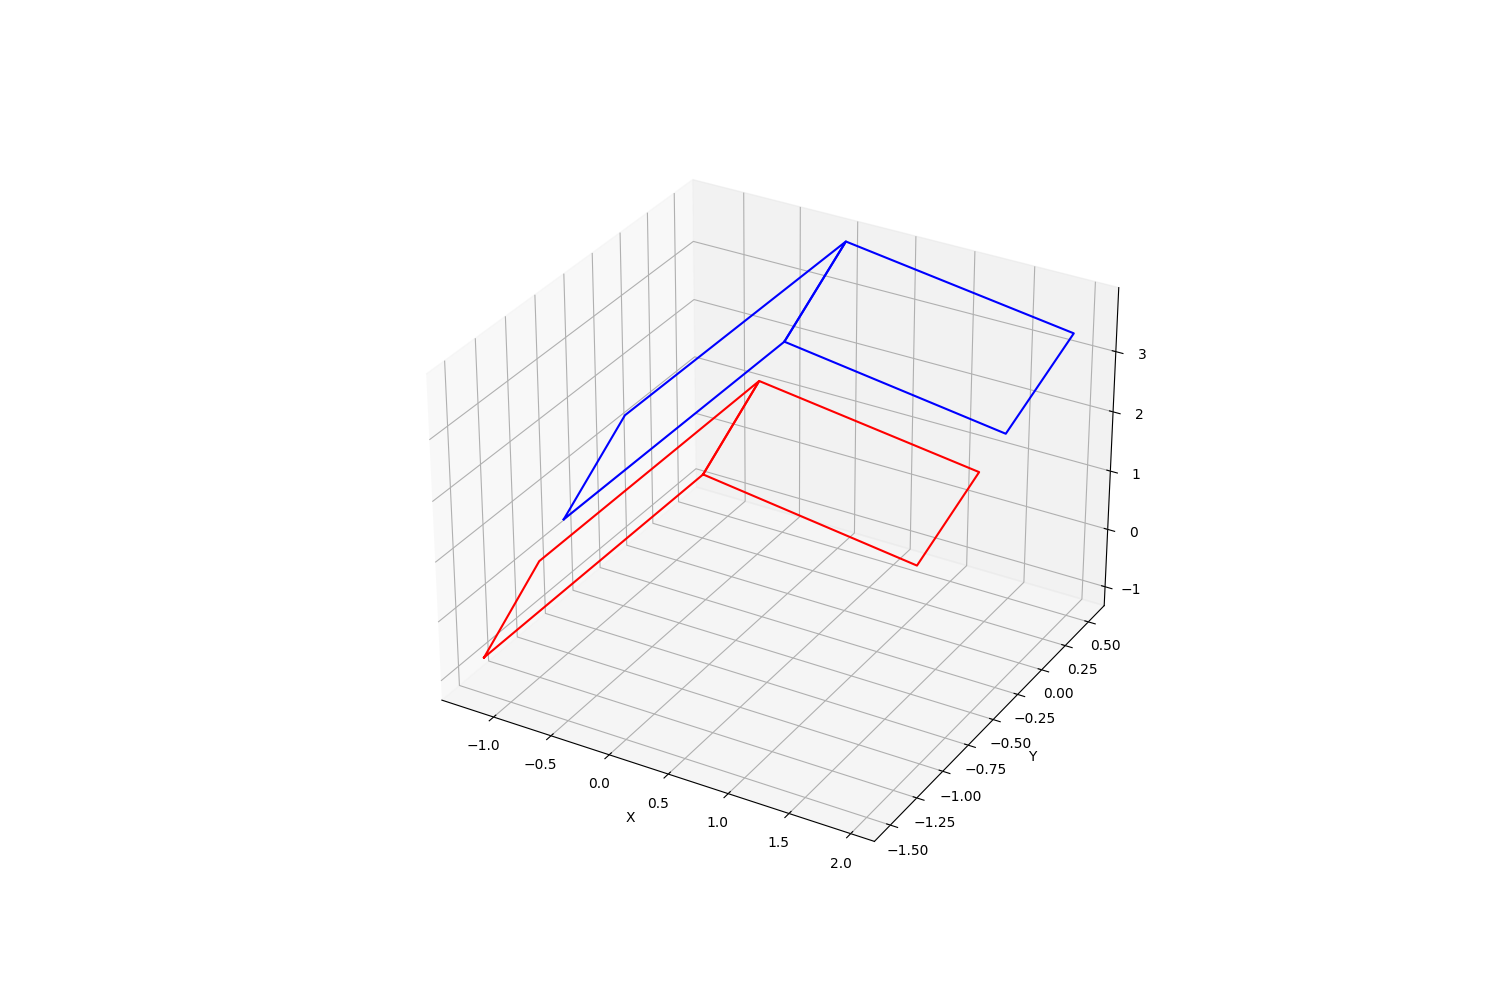

In [102]:
R_est = R.cpu().detach().numpy()[0]
t_est = t.cpu().detach().numpy()

P_t = copy.deepcopy(P)
P_t.transform(R_est, t_est.flatten())

ax = plot_3D_setup()
P_t.plot(ax, color='b')
Q.plot(ax, color='r')

### Test with Airsim data

In [104]:
# Read in point cloud data
binpath = os.path.join(os.getcwd(), '..', '..', 'data', 'airsim', 'blocks_20_samples_1', 'lidar', 'Drone0')
PC_data = io.read_lidar_bin(binpath)

# Read in ground-truth poses (in drone local frame)
posepath = os.path.join(os.getcwd(), '..', '..', 'data', 'airsim', 'blocks_20_samples_1', 'poses', 'Drone0')
drone_positions, drone_orientations = io.read_poses(posepath)

In [105]:
num_scans = len(PC_data)
scans = num_scans * [None]
scans_transformed = num_scans * [None]
for i in range(num_scans):
    scans[i] = pc_to_scan(PC_data[i])

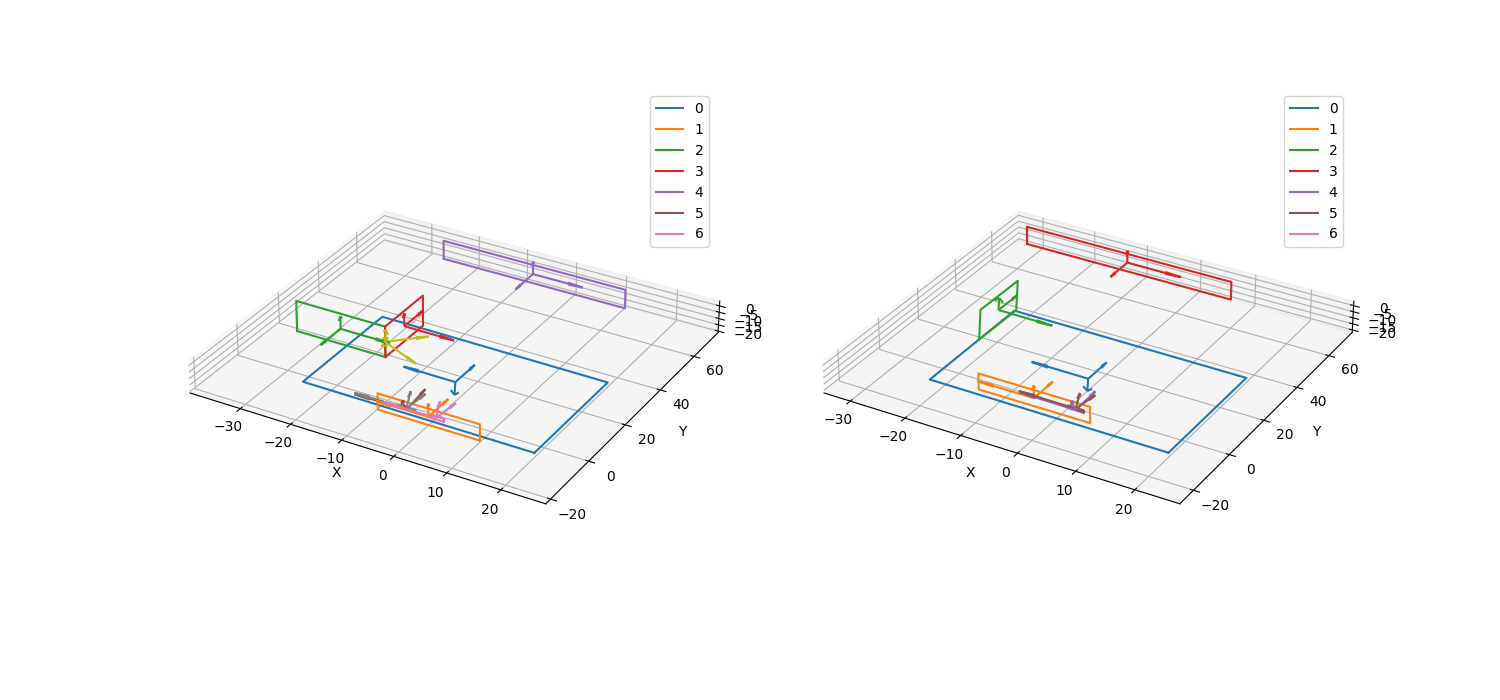

In [120]:
idx_1 = 7
idx_2 = 8

# Plot 2 scans
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax1.set_box_aspect((np.ptp(PC_data[0][:,0]), np.ptp(PC_data[0][:,1]), np.ptp(PC_data[0][:,2])))
ax2.set_box_aspect((np.ptp(PC_data[0][:,0]), np.ptp(PC_data[0][:,1]), np.ptp(PC_data[0][:,2])))
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")

scans[idx_1].plot(ax1, show_normals=True)
scans[idx_2].plot(ax2, show_normals=True)

# Color legend
num_colors = max([len(s.planes) for s in scans[0:2]])
color_legend(ax1, num_colors)
color_legend(ax2, num_colors)

In [111]:
# Ground-truth answer
t_gt = drone_positions[idx_2] - drone_positions[idx_1]
R_0 = quat_to_rot_mat(drone_orientations[idx_1])
R_1 = quat_to_rot_mat(drone_orientations[idx_2])
R_gt = np.linalg.inv(R_0) @ R_1

print(f't_gt: {t_gt} \n R_gt: {R_gt}')

t_gt: [4.94145775e+00 3.08169348e-08 4.38446999e-02] 
 R_gt: [[ 9.99999975e-01  4.28995207e-09  2.24396258e-04]
 [-4.28284228e-09  1.00000000e+00 -3.16845687e-08]
 [-2.24396258e-04  3.16836068e-08  9.99999975e-01]]


In [112]:
# Extract normals and distances
# Use idx_2 as source and idx_1 as target
#correspondences = get_correspondences(scans[idx_2], scans[idx_1])
correspondences = [(0,0), (1,1), (2,3), (3,4)]
n_s, d_s, n_t, d_t = extract_corresponding_features(scans[idx_2], scans[idx_1], correspondences)

In [113]:
# Convert features to torch tensors
n_s = torch.from_numpy(n_s).float().to(device)
d_s = torch.from_numpy(d_s).float().to(device)
n_t = torch.from_numpy(n_t).float().to(device)
d_t = torch.from_numpy(d_t).float().to(device)

In [125]:
# Initial transformation
log_R_init = torch.randn(1, 3, dtype=torch.float32, device=device)
t_init = torch.randn(3, 1, dtype=torch.float32, device=device)

# Instantiate copy of the initialization 
log_R = log_R_init.clone().detach()
log_R.requires_grad = True
t = t_init.clone().detach()
t.requires_grad = True

init_R = so3_exp_map(log_R)
print(f'Init: R = {init_R} \n t = {t}')

# Init the optimizer
optimizer = torch.optim.SGD([log_R, t], lr=0.1, momentum=0.9)
#optimizer = torch.optim.Adam([log_R, t], lr=0.1)

# Run the optimization
n_iter = 100  # fix the number of iterations
start_time = time.time()
for it in range(n_iter):
    # Re-init the optimizer gradients
    optimizer.zero_grad()

    R = so3_exp_map(log_R)

    # Compute loss
    r = residual(R, t, n_s, d_s, n_t, d_t)
    loss = torch.linalg.norm(r)**2

    loss.backward(retain_graph=True)
    
    # Apply the gradients
    optimizer.step()

    # plot and print status message
    if it % 10==0 or it==n_iter-1:
        print(f'Iteration: {it}, loss: {loss}')

print(f'Optimization finished in {time.time() - start_time} seconds.')
print(f'Final: R = {R} \n t = {t}')

Init: R = tensor([[[ 0.8579,  0.1154,  0.5007],
         [ 0.4420,  0.3310, -0.8337],
         [-0.2619,  0.9366,  0.2329]]], device='cuda:0',
       grad_fn=<AddBackward0>) 
 t = tensor([[0.2819],
        [2.3444],
        [0.1010]], device='cuda:0', requires_grad=True)
tensor([[-0.9960],
        [ 1.6535],
        [ 1.5427],
        [ 0.2306],
        [-1.3345],
        [ 1.8732],
        [-0.3012],
        [ 0.9078],
        [-0.5445],
        [-0.2336],
        [ 1.3442],
        [-1.8620],
        [ 3.6097],
        [ 1.8240],
        [-7.1880],
        [-1.8542]], device='cuda:0')
Iteration: 0, loss: 22.36298179626465
tensor([[-1.8333],
        [-0.6927],
        [ 1.7976],
        [ 0.1195],
        [-2.8591],
        [ 1.8035],
        [-2.7105],
        [ 1.6783],
        [ 0.8311],
        [-0.1344],
        [ 2.8623],
        [-1.7864],
        [-3.3489],
        [-2.4418],
        [-6.9971],
        [ 2.3852]], device='cuda:0')
tensor([[-1.9125],
        [-0.3226],
        

In [126]:
def residual(log_R, t, n_s, d_s, n_t, d_t):
    """Residual used to define loss to optimize

    Parameters
    ----------
    log_R : torch.tensor (1 x 3)
        Current parameterized rotation estimate
    t : torch.tensor (3 x 1)
    n_s : np.array (3N x 1)
        Stacked vector of source normals
    d_s : np.array (N x 1)
        Stacked vector of source distances
    n_t : np.array (3N x 1)
        Stacked vector of target normals
    d_t : np.array (N x 1)
        Stacked vector of target distances

    Returns
    -------
    r : np.array (4N x 1)
        Stacked vector of plane-to-plane error residuals
    
    """
    assert len(n_s) % 3 == 0, "Invalid normals vector, length should be multiple of 3"
    N = int(len(n_s) / 3)

    R = so3_exp_map(log_R)
    n_q = (R @ n_s.reshape((N, 3)).T).T.reshape((3*N, 1))
    #n_q =  n_q
    #n_q = n_q.T.reshape((3*N, 1))

    d_q = d_s + n_q.reshape((-1,3)) @ t 

    r = torch.vstack((n_q - n_t, d_q - d_t))
    return r

In [129]:
import torch.autograd.functional as F

F.jacobian(residual, (log_R, t, n_s, d_s, n_t, d_t))

(tensor([[[[-7.1073e-02, -6.0258e-03, -6.1542e-04]]],
 
 
         [[[ 9.9456e-01,  7.1010e-02,  8.5454e-03]]],
 
 
         [[[ 7.3531e-03,  5.4035e-04,  6.3256e-05]]],
 
 
         [[[-8.2575e-03, -5.8889e-04, -1.0178e-03]]],
 
 
         [[[-4.2676e-03, -3.0469e-04, -3.5945e-05]]],
 
 
         [[[ 9.9478e-01,  7.1024e-02,  8.5626e-03]]],
 
 
         [[[-1.0413e-03, -8.9093e-05, -2.1137e-06]]],
 
 
         [[[ 2.4009e-02,  1.7176e-03,  1.1532e-03]]],
 
 
         [[[-7.8181e-02, -6.5332e-03, -6.7070e-04]]],
 
 
         [[[ 7.9784e-03,  5.6523e-04,  1.0154e-03]]],
 
 
         [[[ 8.2028e-03,  5.8568e-04,  7.3155e-05]]],
 
 
         [[[-9.9500e-01, -7.1044e-02, -8.5645e-03]]],
 
 
         [[[-3.8289e-01, -3.2010e-02, -3.3132e-03]]],
 
 
         [[[-1.4136e-01, -1.0089e-02, -5.8645e-03]]],
 
 
         [[[ 2.0205e-03,  1.6828e-04,  1.9175e-05]]],
 
 
         [[[ 1.3988e-01,  9.9655e-03,  5.8515e-03]]]], device='cuda:0'),
 tensor([[[[ 0.0000e+00],
           [ 0.0000e+00],
     